In [3]:
from vibdata.deep.DeepDataset import DeepDataset, convertDataset
import vibdata.raw as raw_datasets
from vibdata.deep.signal.transforms import FilterByValue, Sequential

dataset_name = "CWRU"

# Get raw root_dir
raw_root_dir = "../data/raw_data/cwru"
raw_dataset = getattr(raw_datasets, dataset_name + "_raw")(raw_root_dir, download=True)

deep_root_dir = "../data/deep_data/cwru"
# Get the transforms to be applied
transforms = Sequential(
    [
        #FilterByValue(on_field="sample_rate", values=["12000"])
        FilterByValue(on_field="label", values=[2, 3])
    ]
)

# Convert the raw dataset to deepdataset
# Deep dataset is the dataset compatible with pytorch
convertDataset(dataset=raw_dataset, transforms=transforms, dir_path=deep_root_dir)

# Load the dataset which has been converted
dataset = DeepDataset(deep_root_dir)

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


In [4]:
dataset[0]['signal']

array([[-0.0027614 , -0.09632403,  0.11370459, ..., -0.07829373,
        -0.14911545,  0.02111657]])

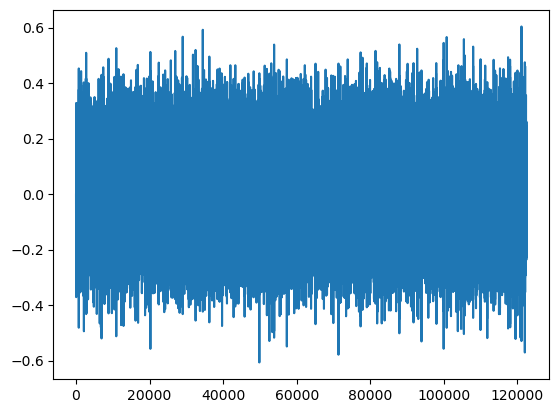

In [5]:
import matplotlib.pyplot as plt
plt.plot(dataset[0]['signal'][0])

In [6]:
from vibdata.deep.signal.transforms import Transform
import matplotlib.pyplot as plt
from scipy.signal import stft
from vibdata.deep.DeepDataset import convertDataset
from vibdata.deep.signal.transforms import Sequential, Split, Transform
import shutil
import numpy as np
import cv2
import pandas as pd
from scipy.signal import ShortTimeFFT, detrend, stft

class OttawaSpectrogram(Transform):
    """Spectrogram transform

    See `scipy.signal.spectrogram` for more information about the parameters.

    This transformation adds the `delta_t` and `delta_f` columns in metainfo for time
    and frequency resolutions.
    """

    def __init__(
        self,
        window="hann",
        nperseg=None,
        noverlap=None,
        nfft=None,
        detrend="linear",
        return_onesided=True,
        axis=-1,
    ):
        super().__init__()
        self.window = window
        self.nperseg = nperseg
        self.noverlap = noverlap
        self.nfft = nfft
        self.detrend = detrend
        self.return_onesided = return_onesided
        self.axis = axis

    def transform(self, data):
        data = data.copy()
        metainfo = data["metainfo"].copy(deep=True)
        signals = data["signal"]

        ret = []
        new_metainfo = []

        for (_, entry), sig in zip(metainfo.iterrows(), signals):
            sig_sample_rate = entry["sample_rate"]
            detrended_data = detrend(sig)
            f, t, Sxx = stft(
                detrended_data,
                fs=sig_sample_rate,
                window=self.window,
                nperseg=self.nperseg,
                noverlap=self.noverlap,
                nfft=self.nfft,
                detrend=self.detrend,
                return_onesided=self.return_onesided,
                axis=self.axis,
            )

            # Compute the thrshold of the frequency limit
            distances = np.abs(f - 10000)
            max_bound = np.argmin(distances)

            # Get the relevant frequencies of the spectogram and 
            float_mat = np.log(np.abs(Sxx[: max_bound+1, :]**2))
            # Normalize the matrix and convert to a grayscale image
            gray_img = ((float_mat - float_mat.min()) / (float_mat.max() - float_mat.min())) * 255
            gray_img = gray_img.astype(np.uint8)
            # Apply color map and convert to rgb image
            bgr_img = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)
            rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
            
            ret.append(rgb_img)
            entry["delta_t"] = t[1] - t[0]
            entry["delta_f"] = f[1] - f[0]
            entry["domain"] = "time-frequency"
            new_metainfo.append(entry)

        data["signal"] = ret
        data["metainfo"] = pd.DataFrame(new_metainfo)
        return data

class Detrend(Transform):

    def __init__(self, field="signal", **kwargs):
        super().__init__()
        self.field = field
        self.kwargs = kwargs

    def transform(self, data):
        data[self.field][0] = detrend(data[self.field][0], **self.kwargs)
        return data

deep_root_dir = "../data/crwu_spectograms/CWRU_sampled_specs"

transforms = Sequential(
    [
        Detrend(),
        Split(12000),
        OttawaSpectrogram(window="hann", nperseg=600, noverlap=int(600 * 0.96), nfft=1600)
    ]
)


deep_dataset = convertDataset(raw_dataset, transforms=transforms, dir_path=deep_root_dir, batch_size=1)

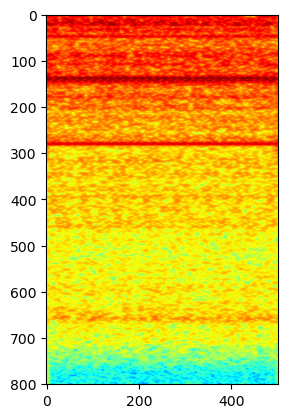

In [7]:
sample = deep_dataset[0]
img = sample["signal"][0]
plt.imshow(img)

In [8]:
import os

import numpy as np
import numpy.typing as npt
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler
from vibdata.deep.DeepDataset import DeepDataset
from vibdata.deep.signal.core import SignalSample


class GroupDataset:
    def __init__(
        self, dataset: DeepDataset, custom_name: str = None, shuffle: bool = False
    ) -> None:
        self.dataset = dataset
        #self.config
        self.shuffle_before_iter = shuffle
        self.groups_dir = "../data/test_group"
        file_name = "groups_" + (custom_name if custom_name else "cwru")
        self.groups_file = os.path.join(self.groups_dir, file_name + ".npy")

    def groups(self) -> npt.NDArray[np.int_]:
        """
        Get the groups from all samples of the dataset. It tries to load from memory at `groups_dir` but if it
        doesnt exists it will compute the groups and save it in `groups_file`.

        Returns:
            npt.NDArray[np.int_]: groups of all dataset
        """
        if os.path.exists(self.groups_file):
            print(f"Loading group dataset from: {self.groups_file}")
            return np.load(self.groups_file,allow_pickle=True)
        else:
            groups = self._random_grouping() if self.shuffle_before_iter else self._sequential_grouping()
            os.makedirs(self.groups_dir, exist_ok=True)  # Ensure that the directory exists
            np.save(self.groups_file, groups)
            return groups

    def _sequential_grouping(self) -> npt.NDArray[np.int_]:
        """Generate the groups iterating sequentially over the dataset

        Returns:
            npt.NDArray[np.int_]: groups of each sample in dataset
        """
        mapped_samples = map(
            self._assigne_group,
            tqdm(self.dataset, total=len(self.dataset), unit="sample", desc="Grouping dataset: "),
        )
        groups = np.array(list(mapped_samples))
        return groups

    def _random_grouping(self) -> npt.NDArray[np.int_]:
        """Generate the groups randomly iterating over the dataset, is equivalent to make a shuffle
        in the dataset. Despite the shuffle, the groups are ordered back to the original order.

        This kind of grouping is needed for datasets where grouping are not predefined

        Returns:
            npt.NDArray[np.int_]: groups of each sample in dataset, in the original order
        """
        # Create the indexes shuffled
        rng = np.random.default_rng(self.config["seed"])  # Ensure thats the seed is correct
        indexs_shuffled = np.arange(len(self.dataset))
        rng.shuffle(indexs_shuffled)
        # Map the dataset ramdomly
        mapped_samples = list(
            map(
                lambda i: self._assigne_group(self.dataset[i]),
                tqdm(indexs_shuffled, total=len(self.dataset), unit="sample", desc="Grouping dataset: "),
            )
        )
        # Sort the output back to the dataset original order
        groups = np.array([value for _, value in sorted(zip(indexs_shuffled, mapped_samples))])
        return groups

    @staticmethod
    def _assigne_group(sample: SignalSample) -> int:
        """
        Get a signal sample and based on the dataset criterion, assigne a group
        to the given sample

        Args:
            sample (SignalSample): sample to be assigned

        Returns:
            int: group id
        """
        pass


class GroupCWRU(GroupDataset):
    @staticmethod
    def _assigne_group(sample: SignalSample) -> int:
        return sample["metainfo"]["load"]


In [9]:
teste = GroupCWRU(deep_dataset)
teste

In [10]:
teste.groups()

Loading group dataset from: ../data/test_group/groups_cwru.npy


array([0., 0., 0., ..., 3., 3., 3.])

In [13]:
import os
import numpy as np
from PIL import Image

# Example dataset and folds (replace with your actual data)
dataset = deep_dataset

folds = teste.groups() # Example fold list (must match the length of the dataset)

# Define the base directory where you want to save the images
base_dir = '../data/fold_images/cwru'

# Create the base directory if it doesn't exist
os.makedirs(base_dir, exist_ok=True)

# Iterate over the dataset and save images in their respective fold folders
for idx, sample in enumerate(dataset):

    label = sample['metainfo']['label']

    fold = int(folds[idx])
    fold_dir = os.path.join(base_dir, f'fold{fold}/{label}')
    
    # Create the fold directory if it doesn't exist
    os.makedirs(fold_dir, exist_ok=True)
    
    # Extract the signal (image) from the sample
    signal = sample['signal']
    
    # Remove the first dimension (1, 801, 501, 3) -> (801, 501, 3)
    signal = np.squeeze(signal, axis=0)
    
    # Invert the length (swap height and width) -> (501, 801, 3) -> 
    signal = np.transpose(signal, (1, 0, 2))
    # Convert the signal array to a PIL image
    if signal.ndim == 3 and signal.shape[2] == 3:  # Check if it's an RGB image
        image = Image.fromarray(signal, 'RGB')
    else:
        raise ValueError("Unsupported signal format. Expected RGB image with shape (H, W, 3).")
    
    # Save the image in the corresponding fold directory
    file_name = f"{idx}.png"  # Change file extension
    save_path = os.path.join(fold_dir, file_name)
    image.save(save_path)
    
    print(f'Saved {save_path}')

print('All images have been saved in their respective fold folders.')

Loading group dataset from: ../data/test_group/groups_cwru.npy
Saved ../data/fold_images/cwru/fold0/0/0.png
Saved ../data/fold_images/cwru/fold0/0/1.png
Saved ../data/fold_images/cwru/fold0/0/2.png
Saved ../data/fold_images/cwru/fold0/0/3.png
Saved ../data/fold_images/cwru/fold0/0/4.png
Saved ../data/fold_images/cwru/fold0/0/5.png
Saved ../data/fold_images/cwru/fold0/0/6.png
Saved ../data/fold_images/cwru/fold0/0/7.png
Saved ../data/fold_images/cwru/fold0/0/8.png
Saved ../data/fold_images/cwru/fold0/0/9.png
Saved ../data/fold_images/cwru/fold0/0/10.png
Saved ../data/fold_images/cwru/fold0/0/11.png
Saved ../data/fold_images/cwru/fold0/0/12.png
Saved ../data/fold_images/cwru/fold0/0/13.png
Saved ../data/fold_images/cwru/fold0/0/14.png
Saved ../data/fold_images/cwru/fold0/0/15.png
Saved ../data/fold_images/cwru/fold0/0/16.png
Saved ../data/fold_images/cwru/fold0/0/17.png
Saved ../data/fold_images/cwru/fold0/0/18.png
Saved ../data/fold_images/cwru/fold0/0/19.png
Saved ../data/fold_images/c

In [59]:
from collections import Counter
import pandas as pd

def get_fold_distribution(folds):
    # Count the number of samples in each fold
    fold_distribution = Counter(folds)
    
    # Convert to a dictionary for better readability
    fold_distribution = dict(fold_distribution)
    
    return fold_distribution

# Example usage
folds = teste.groups()  # Example fold list
distribution = get_fold_distribution(folds)
print("Fold Distribution:", distribution)

# Optional: Convert to a Pandas Series for better visualization
distribution_series = pd.Series(distribution)
print("\nFold Distribution (Pandas Series):")
print(distribution_series)

Loading group dataset from: ../data/test_group/groups_cwru.npy
Fold Distribution: {0.0: 860, 1.0: 1322, 2.0: 1340, 3.0: 1340}

Fold Distribution (Pandas Series):
0.0     860
1.0    1322
2.0    1340
3.0    1340
dtype: int64
